# Mount Drive (Optional)

In [5]:
# Mount Google Drive
from google.colab import drive # import drive from google colab
 
ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)
 
drive.mount(ROOT)           # we mount the google drive at /content/drive


/content/drive
Mounted at /content/drive


# Install Octave-lib

In [ ]:
!apt install octave
!apt install liboctave-dev  # development files
!pip3 install oct2py
from oct2py import Oct2Py
oc = Oct2Py()
script = '''
  function [SDR,SIR,SAR,perm]=bss_eval_sources(se,s)
%%% Errors %%%
if nargin<2, error('Not enough input arguments.'); end
[nsrc,nsampl]=size(se);
[nsrc2,nsampl2]=size(s);
if nsrc2~=nsrc, error('The number of estimated sources and reference sources must be equal.'); end
if nsampl2~=nsampl, error('The estimated sources and reference sources must have the same duration.'); end

%%% Performance criteria %%%
% Computation of the criteria for all possible pair matches
SDR=zeros(nsrc,nsrc);
SIR=zeros(nsrc,nsrc);
SAR=zeros(nsrc,nsrc);
for jest=1:nsrc,
    for jtrue=1:nsrc,
        [s_true,e_spat,e_interf,e_artif]=bss_decomp_mtifilt(se(jest,:),s,jtrue,512);
        [SDR(jest,jtrue),SIR(jest,jtrue),SAR(jest,jtrue)]=bss_source_crit(s_true,e_spat,e_interf,e_artif);
    end
end
% Selection of the best ordering
perm=perms(1:nsrc);
nperm=size(perm,1);
meanSIR=zeros(nperm,1);
for p=1:nperm,
    meanSIR(p)=mean(SIR((0:nsrc-1)*nsrc+perm(p,:)));
end
[meanSIR,popt]=max(meanSIR);
perm=perm(popt,:).';
SDR=SDR((0:nsrc-1).'*nsrc+perm);
SIR=SIR((0:nsrc-1).'*nsrc+perm);
SAR=SAR((0:nsrc-1).'*nsrc+perm);

return;


function [s_true,e_spat,e_interf,e_artif]=bss_decomp_mtifilt(se,s,j,flen)

if nargin<4, error('Not enough input arguments.'); end
[nchan2,nsampl2]=size(se);
[nsrc,nsampl,nchan]=size(s);
if nchan2~=nchan, error('The number of channels of the true source images and the estimated source image must be equal.'); end
if nsampl2~=nsampl, error('The duration of the true source images and the estimated source image must be equal.'); end

%%% Decomposition %%%
% True source image
s_true=[reshape(s(j,:,:),nsampl,nchan).',zeros(nchan,flen-1)];
% Spatial (or filtering) distortion
e_spat=project(se,s(j,:,:),flen)-s_true;
% Interference
e_interf=project(se,s,flen)-s_true-e_spat;
% Artifacts
e_artif=[se,zeros(nchan,flen-1)]-s_true-e_spat-e_interf;

return;


function sproj=project(se,s,flen)

% SPROJ Least-squares projection of each channel of se on the subspace
% spanned by delayed versions of the channels of s, with delays between 0
% and flen-1

[nsrc,nsampl,nchan]=size(s);
s=reshape(permute(s,[3 1 2]),nchan*nsrc,nsampl);

%%% Computing coefficients of least squares problem via FFT %%%
% Zero padding and FFT of input data
s=[s,zeros(nchan*nsrc,flen-1)];
se=[se,zeros(nchan,flen-1)];
fftlen=2^nextpow2(nsampl+flen-1);
sf=fft(s,fftlen,2);
sef=fft(se,fftlen,2);
% Inner products between delayed versions of s
G=zeros(nchan*nsrc*flen);
for k1=0:nchan*nsrc-1,
    for k2=0:k1,
        ssf=sf(k1+1,:).*conj(sf(k2+1,:));
        ssf=real(ifft(ssf));
        ss=toeplitz(ssf([1 fftlen:-1:fftlen-flen+2]),ssf(1:flen));
        G(k1*flen+1:k1*flen+flen,k2*flen+1:k2*flen+flen)=ss;
        G(k2*flen+1:k2*flen+flen,k1*flen+1:k1*flen+flen)=ss.';
    end
end
% Inner products between se and delayed versions of s
D=zeros(nchan*nsrc*flen,nchan);
for k=0:nchan*nsrc-1,
    for i=1:nchan,
        ssef=sf(k+1,:).*conj(sef(i,:));
        ssef=real(ifft(ssef,[],2));
        D(k*flen+1:k*flen+flen,i)=ssef(:,[1 fftlen:-1:fftlen-flen+2]).';
    end
end

%%% Computing projection %%%
% Distortion filters
C=G\D;
C=reshape(C,flen,nchan*nsrc,nchan);
% Filtering
sproj=zeros(nchan,nsampl+flen-1);
for k=1:nchan*nsrc,
    for i=1:nchan,
        sproj(i,:)=sproj(i,:)+fftfilt(C(:,k,i).',s(k,:));
    end
end

return;



function [SDR,SIR,SAR]=bss_source_crit(s_true,e_spat,e_interf,e_artif)


if nargin<4, error('Not enough input arguments.'); end
[nchant,nsamplt]=size(s_true);
[nchans,nsampls]=size(e_spat);
[nchani,nsampli]=size(e_interf);
[nchana,nsampla]=size(e_artif);
if ~((nchant==nchans)&&(nchant==nchani)&&(nchant==nchana)), error('All the components must have the same number of channels.'); end
if ~((nsamplt==nsampls)&&(nsamplt==nsampli)&&(nsamplt==nsampla)), error('All the components must have the same duration.'); end

%%% Energy ratios %%%
s_filt=s_true+e_spat;
% SDR
SDR=10*log10(sum(sum(s_filt.^2))/sum(sum((e_interf+e_artif).^2)))
% SIR
SIR=10*log10(sum(sum(s_filt.^2))/sum(sum(e_interf.^2)));
% SA
SAR=10*log10(sum(sum((s_filt+e_interf).^2))/sum(sum(e_artif.^2)));
return;

         '''

with open("myScript.m","w+") as f:
    f.write(script)

In [6]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz

from scipy.io.wavfile import read, write
from scipy import signal
from sklearn.decomposition import NMF
from sklearn.preprocessing import MinMaxScaler
from helpers2 import *
from numpy import linalg as LA
from numpy.linalg import inv
import seaborn as sns
import warnings
import math
from tqdm import tqdm
warnings.simplefilter('ignore')

In [42]:
def Reconstruct(B,G,Ns,Nm,Yabs,p):
    
    numerators=[]
    B1=B[:,:Ns]
    B2=B[:,Ns:]
    G1=G[:Ns,:]
    G2=G[Ns:,:]
    
    
    numerators.append(np.power(np.matmul(B1,G1),p))
    numerators.append(np.power(np.matmul(B2,G2),p))

    denominator = np.power(np.matmul(B1,G1),p)+np.power(np.matmul(B2,G2),p)
  
    

    Sources=[]
    Masks=[]
    for i in range(2):

        Sources.append(np.multiply(numerators[i]/denominator,Yabs))
        Masks.append(numerators[i]/denominator)

    #print('Source shape = {}'.format(Sources[0].shape))
    
    return Sources,Masks




def SMR(speech, music):
    
    """
    Function that takes music and speech signals.
    returns SMR in db
    """
    speech_power = LA.norm(speech,2)
    music_power = LA.norm(music,2)
    SMR_db=10*np.log10(speech_power/music_power)
    print('SMR = {:.2f}'.format(SMR_db))
    
    return SMR_db

def eval_sdr(D,G_test,Ytest):
  Sources,Masks=Reconstruct(B=D,G=G_test,Yabs=Ytest,p=mask_p,Ns=ns,Nm=nm)

  print('Reconstruction Step .... Done')
  speech_est = Sources[0]
  music_est = Sources[1]

  _, speech_est =  signal.istft(speech_est,
                      samplerate,
                      window = WINDOW,
                      nperseg=WINDOW_SIZE,
                      noverlap=OVERLAP,
                      nfft = NFFT)

  _, music_est =  signal.istft(music_est,
                      samplerate,
                      window = WINDOW,
                      nperseg=WINDOW_SIZE,
                      noverlap=OVERLAP,
                      nfft = NFFT)
 

  sdr_speech = SDR(s_est=speech_est,s=test_s)
  sdr_music = SDR(s_est=music_est, s=test_m)
  print("smr equal = {}".format(SMR_db))

  with open("myScript.m","w+") as f:
    f.write(script)
  print("Speech SDR \n")
  oc.myScript(speech_est ,test_s)
  print("MUSIC SDR \n")
  oc.myScript(music_est ,test_m)

def eval_sdr_out(D,G_test,Ytest,p):
  d = p
  Sources,Masks=Reconstruct(B=D,G=G_test,Ns=16,Nm=48,Yabs=Ytest,p=d)

  print('Reconstruction Step .... Done')
  speech_est = Sources[0]
  music_est = Sources[1]

  _, speech_est =  signal.istft(speech_est,
                      samplerate,
                      window = WINDOW,
                      nperseg=WINDOW_SIZE,
                      noverlap=OVERLAP,
                      nfft = NFFT)

  _, music_est =  signal.istft(music_est,
                      samplerate,
                      window = WINDOW,
                      nperseg=WINDOW_SIZE,
                      noverlap=OVERLAP,
                      nfft = NFFT)

  with open("myScript.m","w+") as f:
    f.write(script)
  print("DNN Results \n")
  speech_sdr = oc.myScript(speech_est ,test_s);
  music_sdr = oc.myScript(music_est ,test_m);

  return speech_sdr,music_sdr

# Load Data

In [8]:
# Best 1-20 min

start = 1 * 60 * 44100
end = 20 * 60 * 44100 

samplerate_s, data_speech = read("/content/drive/MyDrive/Conversation.wav")
speech=data_speech[start:end,0]
length=speech.shape[0]/samplerate_s
print('Shape of the speech {} ... Length : {:.2f}s ... Sample rate : {}'.format(speech.shape[0],length,samplerate_s))

start = 1 * 60 * 44100
end = 20 * 60 * 44100 
samplerate_m, data_music = read("/content/drive/MyDrive/music.wav")
music=data_music[start:end,0]
length=music.shape[0]/samplerate_m
print('Shape of the music {} ... Length : {:.2f}s ... Sample rate : {}'.format(music.shape[0],length,samplerate_m))


Shape of the speech 50274000 ... Length : 1140.00s ... Sample rate : 44100
Shape of the music 50274000 ... Length : 1140.00s ... Sample rate : 44100


# Resampling + Filtering

In [10]:
fs = 16000

rate = samplerate_s / fs


start = 1 * 60 * 44100
end = 20 * 60 * 44100


speech_t=data_speech[start : end, 0]
music_t = data_music[start : end, 0]


speech_t = signal.resample(speech_t,int(speech_t.shape[0]/rate))
music_t = signal.resample(music_t,int(music_t.shape[0]/rate))
samplerate=int(samplerate_m/rate)
length=music_t.shape[0]/samplerate

print('Shape of the test {} ... Length : {:.2f}s ... Sample rate : {}'.format(music_t.shape[0],length,samplerate))

speech = signal.resample(speech,int(speech.shape[0]/rate))
music = signal.resample(music,int(music.shape[0]/rate))


print('Downsampled rate = {}'.format(samplerate))

speech = butter_lowpass_filter(speech,5000,fs)
music = butter_lowpass_filter(music,5000,fs)

music_t = butter_lowpass_filter(music_t,5000,fs)
speech_t = butter_lowpass_filter(speech_t,5000,fs)

Shape of the test 18240000 ... Length : 1140.00s ... Sample rate : 16000
Downsampled rate = 16000


## Test STFT parameters :


In [11]:
fs = 16000
WINDOW = 'hamming'
WINDOW_SIZE=480
OVERLAP = 0.6 * WINDOW_SIZE
NFFT=512
rate = samplerate_s / fs


start = 24 * 60 * 44100
step = int(0.5 * 60 * 44100)

test_s = np.array([])
test_m = np.array([])

for i in range(1):

  test_s = np.hstack([test_s,data_speech[start+i*step:start+(i+1)*step,0]])
  test_m = np.hstack([test_m,data_music[start+i*step:start+(i+1)*step,0]])


test_s = signal.resample(test_s,int(test_s.shape[0]/rate))
test_m = signal.resample(test_m,int(test_m.shape[0]/rate))
samplerate=int(samplerate_m/rate)
length=music_t.shape[0]/samplerate


test_s = butter_lowpass_filter(test_s,5000,fs)
test_m = butter_lowpass_filter(test_m,5000,fs)

## Create the Mixture Signal

In [12]:
################################################################################
SMR_db = 5
test,speech_test,music_test=get_mixed_signal(test_s,test_m,SMR_db)


f,t,Ytest= signal.stft(test,samplerate,window=WINDOW,nperseg=WINDOW_SIZE,noverlap=OVERLAP,nfft=NFFT)
Yabs_test=np.abs(Ytest)

Yabs_test[Yabs_test==0]=0.00001

SMR = 5.00


# Import Trained Dictionnaries

In [14]:
!unrar x -Y "/content/drive/MyDrive/NMF.rar" 
D = np.concatenate([np.load("NMF/Bspeech16.npy" ),np.load("NMF/Bmusic48.npy" )],axis=1)


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/drive/MyDrive/NMF.rar

Creating    NMF                                                       OK
Extracting  NMF/B1616.npy                                                  2%  OK 
Extracting  NMF/B1632.npy                                                  6%  OK 
Extracting  NMF/B1648.npy                                                 12%  OK 
Extracting  NMF/B2424.npy                                                 16%  OK 
Extracting  NMF/B2432.npy                                                 20%  OK 
Extracting  NMF/B3216.npy                                                 24%  OK 
Extracting  NMF/B3232.npy                                                 29%  OK 
Extracting  NMF/B3232comp.npy                                             34%  OK 
Extracting  NMF/B3248.npy                                                

In [16]:
ns = 16 # number of component of speech
nm = 48 # number of component of music

# Warm Start ISTA

In [17]:
from tqdm import tqdm

def soft(z,a,l=0.02):
  h = np.maximum(np.abs(z)-l/a,np.zeros(z.shape[0]))
  return h
  
def warm_start_ISTA(x,W,n_components,a,K,l=0.02):

  np.random.seed(seed=7)
  h = np.random.rand(W.shape[1] , x.shape[1])
  T = x.shape[1]

  for t_ in tqdm(range(1,T)):
    h[:,t_] = h[:,t_-1]

    for _ in range(1,K):
      z = (np.identity(n_components) - (1/a)*(np.transpose(W)@W))@h[:,t_] + \
          (1/a)*np.transpose(W)@x[:,t_]

      h[:,t_] = soft(z,a,l)
  return h 

In [20]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
D_scaled =np.transpose(scaler.fit_transform(np.transpose(D)))


In [40]:
h_ws = warm_start_ISTA(Yabs_test,D_scaled,ns+nm,
                    100000,
                    2,
                    l=0)

mask_p = 0.4

eval_sdr(D_scaled,h_ws,Ytest)

100%|██████████| 2500/2500 [00:00<00:00, 5169.33it/s]


Reconstruction Step .... Done
smr equal = 5
Speech SDR 

SDR =  10.802
MUSIC SDR 

SDR = -9.0940


# Unfolded ISTA

## GPU implementation

In [46]:
import torch
print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

True
cuda:0


In [47]:
f,t,Y= signal.stft(test_s,samplerate,window=WINDOW,nperseg=WINDOW_SIZE,noverlap=OVERLAP,nfft=NFFT)
Y_clean=np.abs(Y)
Y_clean[Y_clean==0]=0.00001
X = Yabs_test
X_cmplx = Ytest
W =scaler.fit_transform(D)
lambd = 0.01
torch.autograd.set_detect_anomaly(False)

## Helpers Functions

In [48]:
def speech_mask(B,G,Ns,p):
    B1=B[:,:Ns]
    B2=B[:,Ns:]
    G1=G[:Ns,:]
    G2=G[Ns:,:]
    
    
    numerator = torch.pow(torch.matmul(B1,G1),p)

    denominator = torch.pow(torch.matmul(B1,G1),p)+torch.pow(torch.matmul(B2,G2),p)
  

    mask_speech = numerator/(denominator+0.00001)

    
    return mask_speech


def soft(z,a,l=0.02):
  h = torch.maximum(torch.abs(z)-l/a,torch.zeros(z.shape[0]).to(device))
  return h


def error(X,M,Y):

  return torch.nn.L1Loss()(Y,M*X)

def Unfolded_ISTA(X, W, alpha, K, lambd,epochs,learning_rate):
  loss_e = 0
  train_hist = np.zeros(epochs)
  epoch_loss = []
  sdr_speech= []
  sdr_music= []
  torch.manual_seed(7)
  X = torch.from_numpy(X).float().to(device)
  W = torch.from_numpy(W).float().to(device)
  W = torch.tile(W, (K,1,1)).to(device)
  alpha_list = list(torch.tile(torch.tensor([alpha]).float(),(K,)))
  H = torch.rand(W.shape[2],X.shape[1]).to(device)
  H = torch.tile(H, (K,1,1)).to(device)
  H_clone = H.clone().to(device)
  Y = torch.from_numpy(Y_clean).float().to(device)
  W1 = W[0]
  W2 = W[1]
  W3 = W[2]
  W4 = W[3]
  W5 = W[4]
  W1.requires_grad = True
  W2.requires_grad = True
  W3.requires_grad = True
  W4.requires_grad = True
  W5.requires_grad = True

  params =  [W1] + [W2]  + [W3] + [W4] + [W5]
  sgd = torch.optim.SGD(params,lr=learning_rate)
  for e in range(epochs):
    for t in tqdm(np.arange(1,X.shape[1]),position=0, leave=True):
      
      for k in range(1,K):
        if k ==1:
          z = (torch.eye(64).to(device) - (1/alpha_list[k])*(W[k-1].t()@W[k-1]))@H[K-1,:,t-1] + (1/alpha_list[k])*W[k-1].t()@X[:,t]

          H[k,:,t] = soft(z,alpha,lambd)
        elif k > 1:
          z = (torch.eye(64).to(device) - (1/alpha_list[k])*(W[k-1].t()@W[k-1]))@H[k-1,:,t] + (1/alpha_list[k])*W[k-1].t()@X[:,t]

          H[k,:,t] = soft(z,alpha,lambd)

        H[k] = torch.maximum(H[k],torch.tensor([0]).to(device))

      sgd.zero_grad()      


      
      mask = speech_mask(torch.maximum(W5,torch.tensor([0]).to(device)),H[K-1],16,2)
      loss = error(X[:,t],mask[:,t],Y[:,t])
      train_hist[e] = loss.item()
      loss.backward()

      sgd.step()
    print(f'Epoch {e} ... Loss = {loss.item()}')
    d = torch.maximum(W5,torch.tensor([0]).to(device)).cpu().detach().numpy()
    d[d == 0] = 0.000001
    h = H.cpu().detach().numpy()
    h[h == 0] = 0.000001
    speech,music = eval_sdr_out(d,h[K-1],Ytest,mask_p)
    sdr_speech.append(speech)
    sdr_music.append(music)
  return d, h[k-1],train_hist,sdr_speech,sdr_music


## DR-NMF Execution

In [51]:
mask_p  = 2
for a in [50]:
  d,h,train_hist,sdr_speech_,sdr_music_ = Unfolded_ISTA(X, W, a, 5, 0,epochs=20,learning_rate= 0.005)
  print("finish")

100%|██████████| 2500/2500 [00:07<00:00, 356.40it/s]


Epoch 0 ... Loss = 7.58485746383667
Reconstruction Step .... Done
DNN Results 

SDR =  10.843
SDR = -3.7614


100%|██████████| 2500/2500 [00:07<00:00, 356.10it/s]


Epoch 1 ... Loss = 5.932102203369141
Reconstruction Step .... Done
DNN Results 

SDR =  12.436
SDR = -0.26158


100%|██████████| 2500/2500 [00:07<00:00, 357.11it/s]


Epoch 2 ... Loss = 5.231649398803711
Reconstruction Step .... Done
DNN Results 

SDR =  12.929
SDR =  0.98138


100%|██████████| 2500/2500 [00:06<00:00, 357.60it/s]


Epoch 3 ... Loss = 4.7953081130981445
Reconstruction Step .... Done
DNN Results 

SDR =  13.143
SDR =  1.5153


100%|██████████| 2500/2500 [00:06<00:00, 358.61it/s]


Epoch 4 ... Loss = 4.538088798522949
Reconstruction Step .... Done
DNN Results 

SDR =  13.230
SDR =  1.7262


100%|██████████| 2500/2500 [00:06<00:00, 357.43it/s]


Epoch 5 ... Loss = 4.312175273895264
Reconstruction Step .... Done
DNN Results 

SDR =  13.339
SDR =  1.9124


100%|██████████| 2500/2500 [00:06<00:00, 357.81it/s]


Epoch 6 ... Loss = 4.148901462554932
Reconstruction Step .... Done
DNN Results 

SDR =  13.375
SDR =  2.0055


100%|██████████| 2500/2500 [00:07<00:00, 355.45it/s]


Epoch 7 ... Loss = 4.030254364013672
Reconstruction Step .... Done
DNN Results 

SDR =  13.397
SDR =  2.0254


100%|██████████| 2500/2500 [00:07<00:00, 354.32it/s]


Epoch 8 ... Loss = 3.951174736022949
Reconstruction Step .... Done
DNN Results 

SDR =  13.406
SDR =  2.0794


100%|██████████| 2500/2500 [00:06<00:00, 361.99it/s]


Epoch 9 ... Loss = 3.8969292640686035
Reconstruction Step .... Done
DNN Results 

SDR =  13.429
SDR =  2.0949


100%|██████████| 2500/2500 [00:06<00:00, 357.16it/s]


Epoch 10 ... Loss = 3.843212366104126
Reconstruction Step .... Done
DNN Results 

SDR =  13.432
SDR =  2.1309


100%|██████████| 2500/2500 [00:07<00:00, 354.88it/s]


Epoch 11 ... Loss = 3.721219778060913
Reconstruction Step .... Done
DNN Results 

SDR =  13.449
SDR =  2.1572


100%|██████████| 2500/2500 [00:06<00:00, 357.75it/s]


Epoch 12 ... Loss = 3.6199519634246826
Reconstruction Step .... Done
DNN Results 

SDR =  13.470
SDR =  2.1756


100%|██████████| 2500/2500 [00:07<00:00, 356.08it/s]


Epoch 13 ... Loss = 3.5943851470947266
Reconstruction Step .... Done
DNN Results 

SDR =  13.476
SDR =  2.1762


100%|██████████| 2500/2500 [00:07<00:00, 354.10it/s]


Epoch 14 ... Loss = 3.5789871215820312
Reconstruction Step .... Done
DNN Results 

SDR =  13.493
SDR =  2.1893


100%|██████████| 2500/2500 [00:07<00:00, 347.95it/s]


Epoch 15 ... Loss = 3.5655760765075684
Reconstruction Step .... Done
DNN Results 

SDR =  13.483
SDR =  2.1455


100%|██████████| 2500/2500 [00:07<00:00, 353.36it/s]


Epoch 16 ... Loss = 3.5516843795776367
Reconstruction Step .... Done
DNN Results 

SDR =  13.491
SDR =  2.1411


100%|██████████| 2500/2500 [00:07<00:00, 356.50it/s]


Epoch 17 ... Loss = 3.534334421157837
Reconstruction Step .... Done
DNN Results 

SDR =  13.501
SDR =  2.1246


100%|██████████| 2500/2500 [00:06<00:00, 357.43it/s]


Epoch 18 ... Loss = 3.4995462894439697
Reconstruction Step .... Done
DNN Results 

SDR =  13.519
SDR =  2.1094


100%|██████████| 2500/2500 [00:07<00:00, 356.27it/s]


Epoch 19 ... Loss = 3.4877166748046875
Reconstruction Step .... Done
DNN Results 

SDR =  13.523
SDR =  2.1080
finish


In [71]:
def plot_sdr_loss(sdr_speech,sdr_music,loss):
  hist1 = loss
  hist2 = sdr_speech_
  hist3 = sdr_music_
  plt.style.use('seaborn-paper')

  fig,ax=plt.subplots(1,1,sharex=True,figsize=(15,8),dpi=400)
  ax2=ax.twinx()

  x1=ax.plot(np.arange(0,len(hist2),1),hist2,'b',linewidth=2)
  x2=ax.plot(np.arange(0,len(hist3),1),hist3,'g',linewidth=2)

  x3=ax2.plot(np.arange(0,len(hist1),1),hist1,'r',linewidth=2)

  ax.set_ylabel('SDR ',fontsize=20)
  ax2.set_ylabel('SDR ',fontsize=20)
  ax2.set_ylabel('Loss',fontsize=20)
  ax.set_xticks([0,5,10,15,20])

  ax.set_xlabel('Epochs',fontsize=20)


  ax.tick_params(axis='both', which='major', labelsize=12)
  ax2.tick_params(axis='both', which='major', labelsize=12)


  ax.grid(linestyle='--',linewidth=1)
  """
  ax2.set_ylim(6.3, 7.1)
  ax.set_ylim(0, 0.4)
  """

  ax.legend(x1+x2+x3,['SDR Speech','SDR Music','Loss'],loc=4, prop={'size': 16},bbox_to_anchor=(1.25, 0.88),fancybox=True, shadow=True,borderaxespad=0.1,title=' SMR = {}'.format(SMR_db),title_fontsize=15)
  

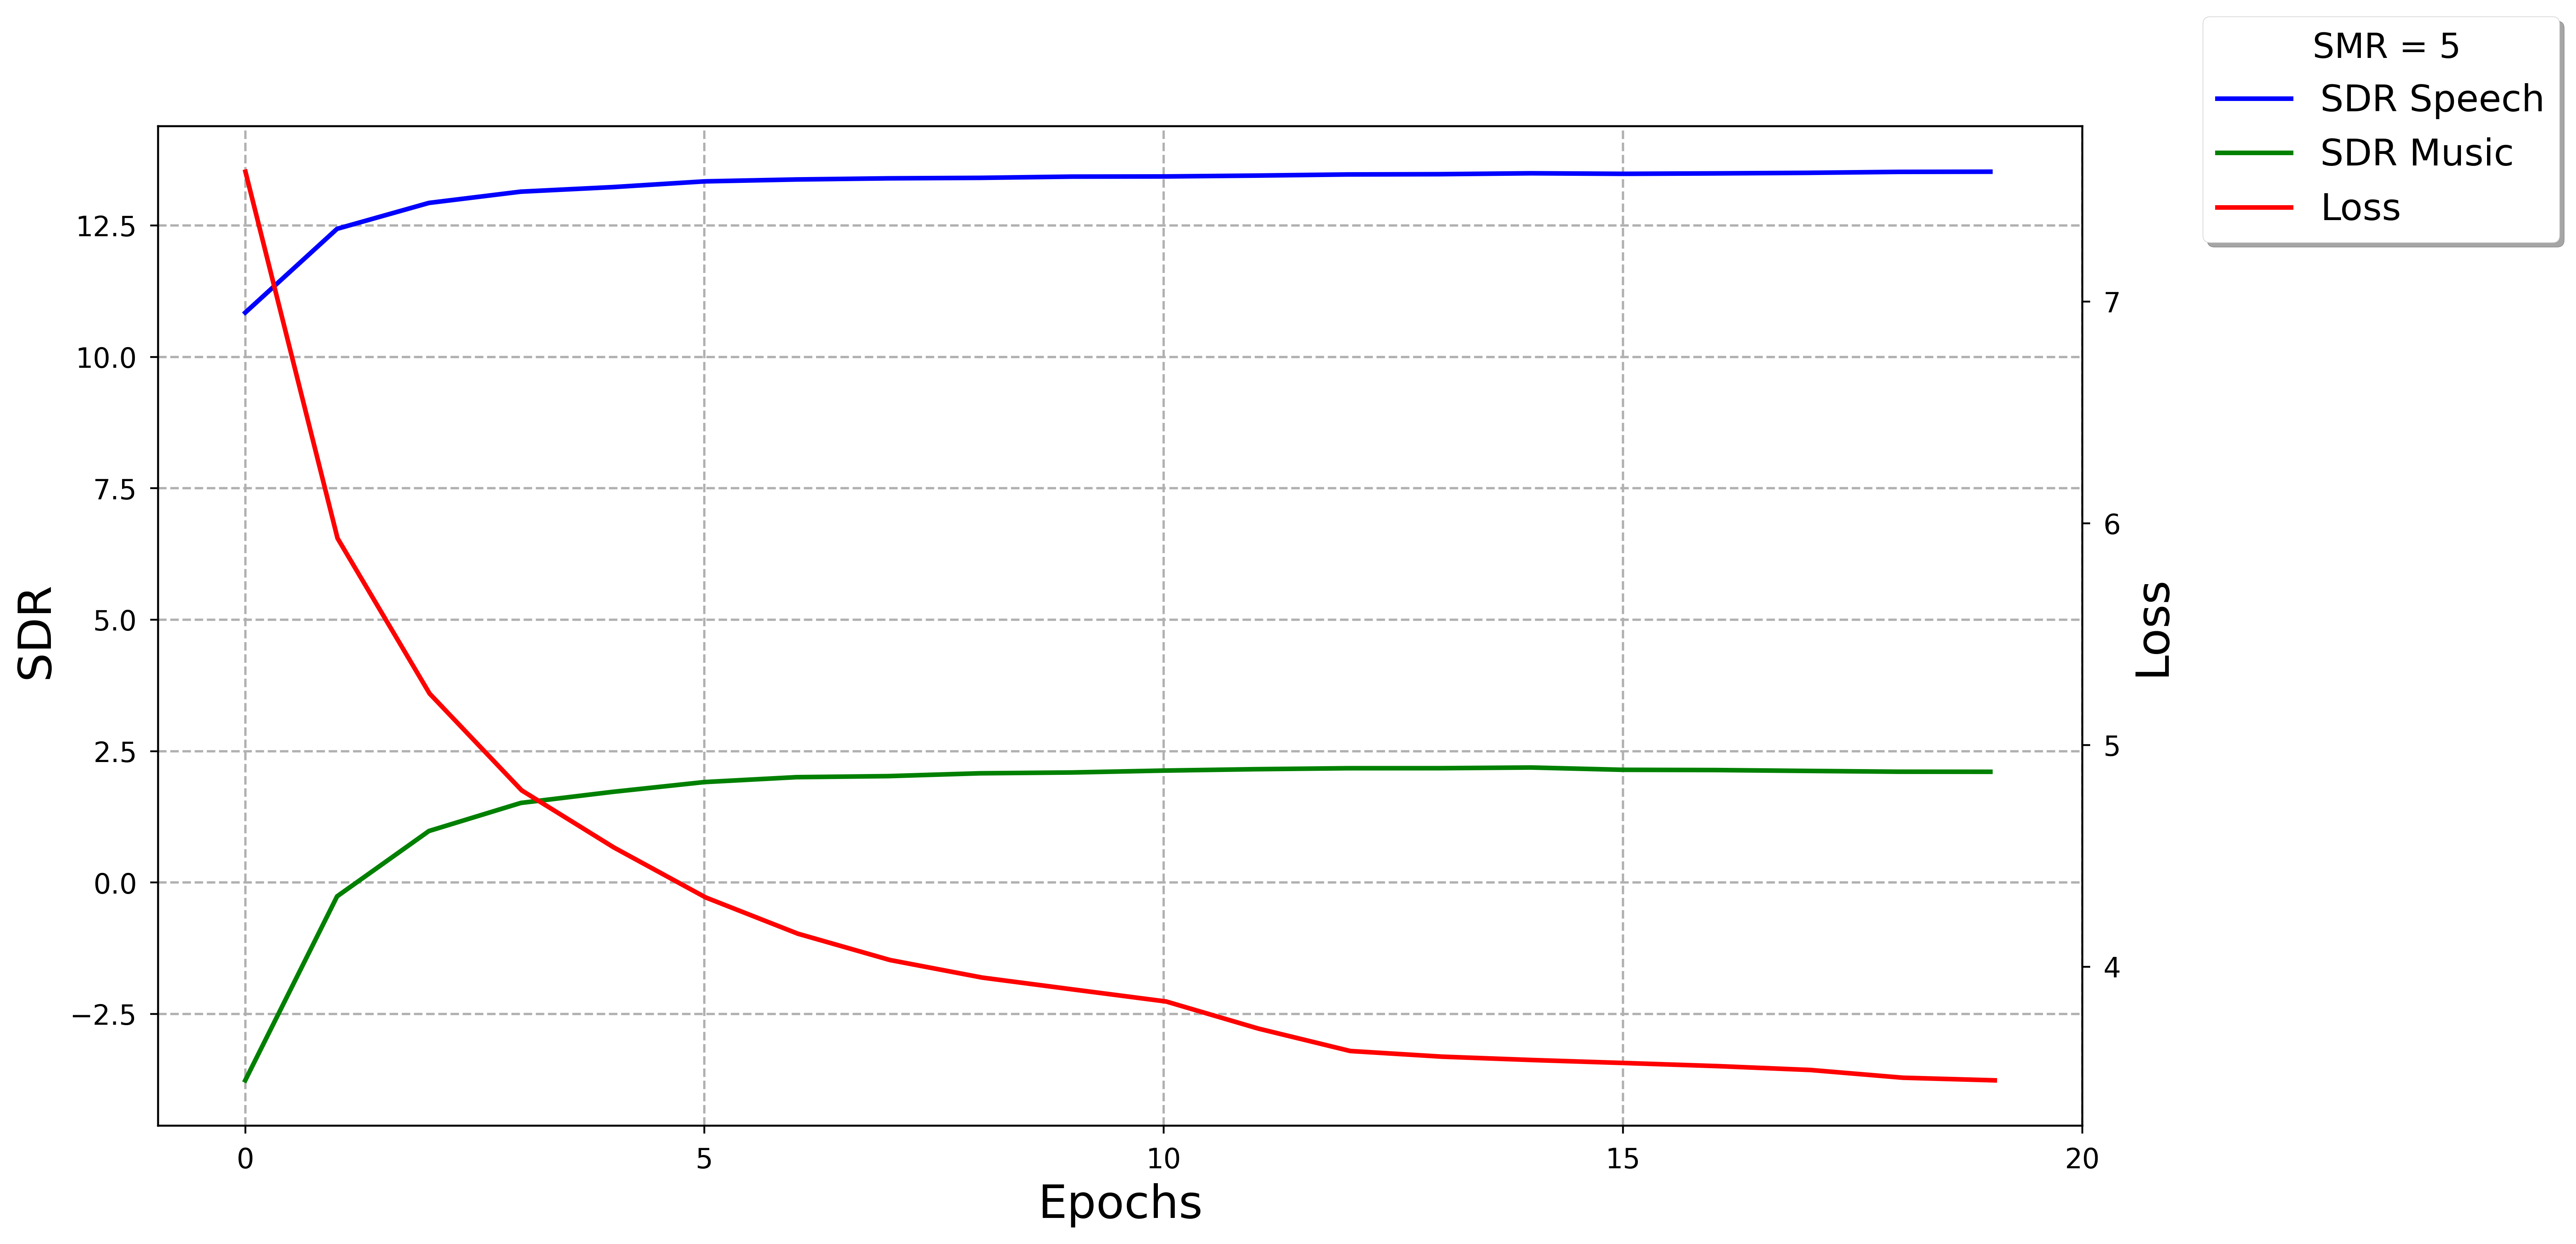

In [72]:
plot_sdr_loss(sdr_speech_,sdr_music_,train_hist)
plt.savefig('/content/drive/MyDrive/ISTA_results/SMR_5_graph',bbox_inches='tight')